# Topic Modeling with SciKit Learn

In this notebook we create a topic model from our corpus  using SciKit Learn's library. We'll save our results and then use another notebook to explore the results.

# Set Up

## Imports

In [1]:
import pandas as pd
import numpy as np
from lib import tapi

## Configuration

In [2]:
tapi.list_corpora()

['airbnb',
 'anphoblacht',
 'arxiv',
 'covid19',
 'jstor_hyperparameter',
 'novels',
 'okcupid',
 'tamilnet',
 'winereviews',
 'yelp',
 'zuboff']

In [3]:
# data_prefix = 'winereviews'
data_prefix = 'okcupid'

In [4]:
db = tapi.Edition(data_prefix)

## Parameters

In [5]:
n_terms = 4000 # Vocabulary size
ngram_range = (1,4) # ngram min and max lengths
n_topics = 20 # Number of topics
max_iter = 5 # Number of iterations for topic model

## Create Tables Object

These tables constitute a "digital critical edition."

# Import Corpus Data

We import a corpus in our standard format

In [6]:
corpus = db.get_corpus()

## Inspect contents

In [7]:
corpus.head(10)

,doc_key,doc_age,doc_body_type,doc_diet,doc_drinks,doc_drugs,doc_education,doc_ethnicity,doc_height,doc_income,...,doc_sign,doc_smokes,doc_speaks,doc_status,doc_content,doc_religion_type,doc_religion_level,doc_city,doc_label,doc_title
doc_id,,,,,,,,,,,,,,,,,,,,,
0,32135,46,fit,anything,socially,never,graduated from college/university,white,62.0,-1,...,taurus but it doesn&rsquo;t matter,no,english,single,first things first my goofy handle i really ju...,atheism,laughing about it,emeryville,f,Profile 32135
1,50546,29,NaN,NaN,socially,NaN,graduated from college/university,white,66.0,-1,...,virgo,no,english,single,i moved here from the east coast 6 years ago a...,x,x,san francisco,f,Profile 50546
2,28147,26,fit,mostly anything,socially,never,graduated from college/university,white,69.0,30000,...,virgo and it&rsquo;s fun to think about,sometimes,english,single,i am currently living in half moon bay and wor...,agnosticism,not too serious about it,half moon bay,m,Profile 28147
3,59659,29,average,NaN,socially,sometimes,graduated from college/university,white,70.0,-1,...,aries and it&rsquo;s fun to think about,sometimes,english,single,born and raised in san francisco currently coo...,x,x,san francisco,m,Profile 59659
4,11536,48,fit,strictly anything,socially,never,graduated from college/university,white,70.0,-1,...,leo but it doesn&rsquo;t matter,no,"english (fluently), spanish (poorly)",single,when i m out i enjoy things such as seeing liv...,agnosticism,somewhat serious about it,oakland,m,Profile 11536
5,21489,18,average,strictly anything,socially,sometimes,working on college/university,NaN,62.0,1000000,...,sagittarius,sometimes,english,single,so i am mostly looking for smoking buddies or ...,atheism,x,san francisco,f,Profile 21489
6,58178,23,athletic,NaN,socially,never,working on two-year college,black,68.0,-1,...,taurus,no,english,single,hi my name is mario i m 23 i play simi pro foo...,christianity,x,hayward,m,Profile 58178
7,53921,45,fit,mostly anything,not at all,never,graduated from masters program,white,63.0,-1,...,virgo and it&rsquo;s fun to think about,no,"english (fluently), french (okay), spanish (po...",single,seeking a partner for friendship romance mutua...,buddhism,not too serious about it,berkeley,f,Profile 53921
8,42101,29,fit,mostly anything,socially,never,graduated from college/university,black,68.0,-1,...,virgo but it doesn&rsquo;t matter,no,english,single,i m one of the rare people currently residing ...,agnosticism,x,san francisco,f,Profile 42101


In [8]:
corpus.shape

(9610, 26)

In [9]:
corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9610 entries, 0 to 9999
Data columns (total 26 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   doc_key             9610 non-null   int64  
 1   doc_age             9610 non-null   int64  
 2   doc_body_type       8812 non-null   object 
 3   doc_diet            5805 non-null   object 
 4   doc_drinks          9166 non-null   object 
 5   doc_drugs           7309 non-null   object 
 6   doc_education       8620 non-null   object 
 7   doc_ethnicity       8749 non-null   object 
 8   doc_height          9610 non-null   float64
 9   doc_income          9610 non-null   int64  
 10  doc_job             8331 non-null   object 
 11  doc_last_online     9610 non-null   object 
 12  doc_location        9610 non-null   object 
 13  doc_offspring       4001 non-null   object 
 14  doc_orientation     9610 non-null   object 
 15  doc_pets            6481 non-null   object 
 16  doc_si

# Create Bag-of-Words 

ie. a __Count Vector Space__

We use Scikit Learn's CountVectorizer to convert our F1 corpus of paragraphs into a document-term vector space of word counts.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [11]:
count_engine = CountVectorizer(max_features=n_terms, stop_words='english', ngram_range=ngram_range)
count_model = count_engine.fit_transform(corpus.doc_content)

In [12]:
# corpus.doc_content

## Get Generated VOCAB

In [13]:
db.VOCAB = pd.DataFrame(count_engine.get_feature_names(), columns=['term_str'])
db.VOCAB = db.VOCAB.set_index('term_str')
db.VOCAB['ngram_len'] = None # To be added later
# VOCAB.index.name = 'term_id' # For convenience, we'll use strings for IDs

In [14]:
db.VOCAB.sample(10)

,ngram_len
term_str,
thoughts,None
view,None
sensual,None
indie rock,None
heads,None
consultant,None
new world,None
grow,None
ray,None


## Get Generated BOW

We do this just to show what the counter vectorizer produced. `DTM` stands for documet-term matrix. We convert this sparse matrix into a "thin" dataframe that keeps only terms with counts for each document. 

In [15]:
db.DTM = pd.DataFrame(count_model.toarray(), index=corpus.index, columns=db.VOCAB.index)
db.BOW = db.DTM.stack().to_frame('n')
db.BOW = db.BOW[~(db.BOW.n == 0)]

In [16]:
# db.BOW.head(10)

In [17]:
db.DTM.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9610 entries, 0 to 9999
Columns: 4000 entries, 10 to zone
dtypes: int64(4000)
memory usage: 293.6 MB


In [18]:
db.BOW.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1278169 entries, (0, '40') to (9999, 'write')
Columns: 1 entries, n to n
dtypes: int64(1)
memory usage: 15.1+ MB


## Compute TF-IDF

In [19]:
tfidf_engine = TfidfTransformer()
tfidf_model = tfidf_engine.fit_transform(count_model)

In [20]:
db.TFIDF = pd.DataFrame(tfidf_model.toarray(), index=corpus.index, columns=db.VOCAB.index)

In [21]:
db.BOW['tfidf'] = db.TFIDF.stack()

In [22]:
db.BOW

n     tfidf
doc_id term_str                   
0      40              2  0.110918
       50              1  0.059843
       80              3  0.162481
       activities      1  0.047111
       actually        2  0.073186
...                   ..       ...
9999   watching        1  0.070868
       watching movie  1  0.112145
       work            1  0.051106
       wouldn          1  0.115292
       write           1  0.097434

[1278169 rows x 2 columns]

## Add Features to VOCAB

In [23]:
db.VOCAB['ngram_len'] = db.VOCAB.apply(lambda x: len(x.name.split()), 1)
db.VOCAB['n'] = db.DTM.sum()
db.VOCAB['tfidf_mean'] = db.TFIDF.mean()

In [24]:
db.VOCAB

,ngram_len,n,tfidf_mean
term_str,,,
10,1,637,0.004254
10 years,2,170,0.001573
100,1,285,0.002246
11,1,205,0.001724
12,1,298,0.002266
...,...,...,...
zero,1,142,0.001242
zombie,1,262,0.002042
zombie apocalypse,2,84,0.000793


<AxesSubplot:>

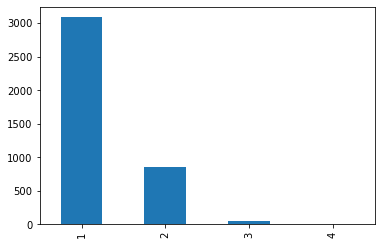

In [25]:
db.VOCAB.ngram_len.value_counts().plot.bar()

# Generate Topic Models

We run Scikit Learn's [LatentDirichletAllocation algorithm](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html#sklearn.decomposition.LatentDirichletAllocation) and extract the THETA and PHI tables.

In [26]:
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF

## Using LDA

In [27]:
lda_engine = LDA(n_components=n_topics, max_iter=max_iter, learning_offset=50., random_state=0)

### THETA

In [28]:
db.THETA = pd.DataFrame(lda_engine.fit_transform(count_model), index=corpus.index)
db.THETA.index.name = 'doc_id'
db.THETA.columns.name = 'topic_id'

In [29]:
db.THETA.sample(20).T.style.background_gradient()

doc_id,8565,5643,3632,9956,3193,37,558,4619,6749,8036,5628,9627,5515,1133,2788,3600,4542,7549,8188,6619
topic_id,,,,,,,,,,,,,,,,,,,,
0,0.000347,0.000291,0.001020,0.000420,0.000323,0.000180,0.000064,0.000251,0.000575,0.000272,0.448419,0.000735,0.001064,0.113290,0.000193,0.000242,0.000446,0.004167,0.000463,0.381135
1,0.000347,0.000291,0.001020,0.000420,0.000323,0.000180,0.000064,0.000251,0.000575,0.000272,0.000291,0.000735,0.157490,0.000158,0.000193,0.000242,0.000446,0.004167,0.000463,0.000485
2,0.271279,0.000291,0.857629,0.000420,0.000323,0.000180,0.000064,0.000251,0.000575,0.238283,0.195845,0.000735,0.001064,0.051766,0.492819,0.771808,0.000446,0.004167,0.000463,0.000485
3,0.399909,0.189161,0.001020,0.000420,0.540196,0.000180,0.000064,0.297798,0.000575,0.000272,0.000291,0.000735,0.001064,0.000158,0.000193,0.223844,0.255805,0.004167,0.574243,0.000485
4,0.000347,0.000291,0.001020,0.000420,0.000323,0.206755,0.000064,0.000251,0.000575,0.000272,0.177094,0.000735,0.435007,0.000158,0.000193,0.000242,0.000446,0.004167,0.000463,0.167090
5,0.000347,0.000291,0.001020,0.000420,0.000323,0.000180,0.000064,0.000251,0.000575,0.000272,0.000291,0.192192,0.001064,0.000158,0.000193,0.000242,0.000446,0.004167,0.000463,0.000485
6,0.000347,0.000291,0.124004,0.000420,0.000323,0.000180,0.000064,0.000251,0.000575,0.000272,0.150032,0.000735,0.001064,0.138062,0.000193,0.000242,0.000446,0.004167,0.000463,0.366970
7,0.000347,0.000291,0.001020,0.082648,0.000323,0.000180,0.000064,0.000251,0.000575,0.000272,0.000291,0.000735,0.389418,0.000158,0.000193,0.000242,0.000446,0.004167,0.037938,0.000485
8,0.000347,0.000291,0.001020,0.138441,0.155280,0.000180,0.285543,0.213726,0.000575,0.000272,0.024248,0.000735,0.001064,0.000158,0.000193,0.000242,0.000446,0.004167,0.000463,0.000485


### PHI

In [30]:
db.PHI = pd.DataFrame(lda_engine.components_, columns=db.VOCAB.index)
db.PHI.index.name = 'topic_id'
db.PHI.columns.name  = 'term_str'

In [31]:
db.PHI.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
term_str,,,,,,,,,,,,,,,,,,,,
10,31.269609,0.468622,26.081621,81.091354,20.407717,4.709759,20.479896,4.049438,44.638321,32.597624,82.643837,7.482214,0.050000,1.766222,12.988149,93.440436,15.722448,58.789778,71.720282,27.602672
10 years,15.512950,0.700818,6.087054,38.520903,6.014727,2.212320,9.181341,0.050000,7.675339,23.476161,30.844537,0.355421,0.050000,0.050000,1.991113,6.724631,0.835697,4.651435,5.813075,10.252476
100,7.800163,4.088454,24.393049,7.489415,7.075656,0.928202,4.012839,3.121992,21.296745,19.264516,27.458448,1.335790,1.450728,0.272893,7.199045,52.754143,14.285660,22.236611,49.689096,9.846555
11,8.536405,1.754458,12.966195,19.595390,9.193932,0.894224,4.512877,6.419498,10.623149,16.346914,18.726948,0.056572,0.050000,0.050000,1.343686,39.747175,2.602933,11.258374,34.589952,6.731317
12,17.684722,1.525245,14.906408,7.783734,10.346041,0.050185,4.777126,4.406978,27.669384,24.000387,37.820830,8.725368,0.050000,2.850805,4.918375,48.842210,12.488515,21.828297,45.277856,3.047532


### Create Topic Glosses

In [32]:
n_top_words = 7

In [33]:
db.TOPICS = db.PHI.stack()\
    .to_frame('weight')\
    .groupby('topic_id')\
    .apply(lambda x: x.weight.sort_values(ascending=False)\
               .head(n_top_words)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [34]:
db.TOPICS

term_str,0,1,2,3,4,5,6
topic_id,,,,,,,
0,love,like,people,new,life,music,good
1,blah,blah blah,blah blah blah,music,kung,kung fu,fu
2,love,life,friends,good,family,music,time
3,like,friends,work,good,food,love,time
4,like,love,food,good,music,movies,favorite
5,com,http,www,http www,like,time,life
6,friends,love,new,family,like,work,fun
7,music,love,food,people,black,good,making
8,music,love,like,movies,books,food,good


In [35]:
db.TOPICS['topwords'] = db.TOPICS.apply(lambda x: str(x.name) + ' ' + ', '.join(x), 1)

In [36]:
db.TOPICS

term_str,0,1,2,3,4,5,6,topwords
topic_id,,,,,,,,
0,love,like,people,new,life,music,good,"0 love, like, people, new, life, music, good"
1,blah,blah blah,blah blah blah,music,kung,kung fu,fu,"1 blah, blah blah, blah blah blah, music, kung..."
2,love,life,friends,good,family,music,time,"2 love, life, friends, good, family, music, time"
3,like,friends,work,good,food,love,time,"3 like, friends, work, good, food, love, time"
4,like,love,food,good,music,movies,favorite,"4 like, love, food, good, music, movies, favorite"
5,com,http,www,http www,like,time,life,"5 com, http, www, http www, like, time, life"
6,friends,love,new,family,like,work,fun,"6 friends, love, new, family, like, work, fun"
7,music,love,food,people,black,good,making,"7 music, love, food, people, black, good, making"
8,music,love,like,movies,books,food,good,"8 music, love, like, movies, books, food, good"


### Add Doc Weights

In [37]:
db.TOPICS['doc_weight_sum'] = db.THETA.sum()

In [38]:
db.TOPICS.iloc[:, 7:].sort_values('doc_weight_sum', ascending=False).style.bar()

term_str,topwords,doc_weight_sum
topic_id,,
18,"18 like, don, people, good, really, just, know",1328.040810
19,"19 love, good, friends, like, people, time, new",867.676749
2,"2 love, life, friends, good, family, music, time",833.767233
17,"17 like, really, movies, time, just, games, don",709.848413
0,"0 love, like, people, new, life, music, good",699.172807
15,"15 like, time, things, people, ve, life, just",698.465676
8,"8 music, love, like, movies, books, food, good",606.960618
3,"3 like, friends, work, good, food, love, time",586.822406
10,"10 like, ve, just, people, don, new, really",545.585282


## Using NMF

In [39]:
nmf_engine = NMF(n_components=n_topics, init='nndsvd', random_state=1, alpha=.1, l1_ratio=.5)

### THETA

In [40]:
db.THETA_NMF = pd.DataFrame(nmf_engine.fit_transform(tfidf_model), index=corpus.index)
db.THETA_NMF.columns.name = 'topic_id'

In [41]:
db.THETA_NMF.sample(20).style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
doc_id,,,,,,,,,,,,,,,,,,,,
2934,0.012015,0.019295,0.000000,0.025038,0.015846,0.000000,0.000000,0.000000,0.000763,0.006655,0.018308,0.000000,0.000000,0.000000,0.000000,0.000157,0.000000,0.000000,0.000000,0.000000
4788,0.033976,0.006146,0.000000,0.008576,0.006978,0.030481,0.000000,0.014009,0.000000,0.000903,0.000000,0.000000,0.016364,0.018315,0.000000,0.000000,0.000000,0.000000,0.003636,0.020859
1521,0.000000,0.000000,0.000000,0.002336,0.029481,0.001693,0.000000,0.000000,0.000000,0.000000,0.000484,0.000000,0.000000,0.000000,0.000000,0.000000,0.001622,0.000000,0.000000,0.000000
5125,0.016093,0.011430,0.000000,0.041879,0.000000,0.000000,0.000000,0.000604,0.000000,0.000000,0.000000,0.000000,0.000672,0.000000,0.028081,0.000000,0.003818,0.000000,0.000000,0.000000
8595,0.012623,0.000316,0.000000,0.000000,0.021472,0.000000,0.000000,0.003076,0.009872,0.000000,0.026291,0.040119,0.001557,0.000000,0.005862,0.000000,0.000000,0.000000,0.006550,0.005310
375,0.021204,0.008464,0.000000,0.027201,0.000000,0.004778,0.000000,0.000000,0.000000,0.000000,0.000464,0.000000,0.000000,0.000000,0.012295,0.000000,0.004115,0.000000,0.000000,0.000000
2897,0.030628,0.011993,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.023150,0.003379,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.012168,0.000000,0.000000
4100,0.012914,0.025249,0.000000,0.012613,0.000000,0.000410,0.000000,0.000000,0.000000,0.000000,0.028094,0.000000,0.012353,0.000000,0.000000,0.000000,0.000000,0.000000,0.019104,0.023202
795,0.001878,0.032422,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033208,0.000120,0.000000


### PHI

In [42]:
db.PHI_NMF = pd.DataFrame(nmf_engine.components_, columns=db.VOCAB.index)

In [43]:
db.PHI_NMF.index.name = 'topic_id'
db.PHI_NMF.columns.name = 'term_str'

In [44]:
db.PHI_NMF.T.head().style.background_gradient()

topic_id,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
term_str,,,,,,,,,,,,,,,,,,,,
10,0.124420,0.040184,0.000000,0.026553,0.020922,0.000000,0.000000,0.000000,0.000000,0.000000,0.011712,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10 years,0.036285,0.026867,0.000000,0.000000,0.007954,0.008649,0.000000,0.000000,0.000000,0.000000,0.008436,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
100,0.063180,0.000000,0.000000,0.015479,0.023914,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,0.054924,0.000000,0.000000,0.000000,0.012873,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,0.055018,0.000000,0.000000,0.037068,0.020630,0.000388,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


### Topics

In [45]:
db.TOPICS_NMF = db.PHI_NMF.stack()\
    .to_frame('weight')\
    .groupby('topic_id')\
    .apply(lambda x: 
           x.weight.sort_values(ascending=False)\
               .head(n_top_words)\
               .reset_index()\
               .drop('topic_id',1)\
               .term_str)

In [46]:
db.TOPICS_NMF

term_str,0,1,2,3,4,5,6
topic_id,,,,,,,
0,don,just,really,ve,people,think,like
1,friends,family,family friends,going,friends family,enjoy,work
2,im,dont,lol,ive,ill,just,alot
3,movies,shows,books,tv,food,black,rock
4,world,open,enjoy,life,love,art,dancing
5,bay,area,bay area,moved,years,moved bay,moved bay area
6,http,com,www,http www,www youtube,www youtube com,youtube com
7,like,don like,really like,movies like,feel like,movies,stuff
8,love,laugh,love laugh,smile,love love,food love,love travel


In [47]:
db.TOPICS_NMF['topwords'] = db.TOPICS_NMF.apply(lambda x: str(x.name) + ' ' + ', '.join(x), 1)

### Add Doc Weights

In [48]:
db.TOPICS_NMF['doc_weight_sum'] = db.THETA_NMF.sum()

In [49]:
db.TOPICS_NMF.iloc[:, 7:].sort_values('doc_weight_sum', ascending=False).style.bar()

term_str,topwords,doc_weight_sum
topic_id,,
0,"0 don, just, really, ve, people, think, like",216.329718
4,"4 world, open, enjoy, life, love, art, dancing",126.148561
3,"3 movies, shows, books, tv, food, black, rock",117.094023
1,"1 friends, family, family friends, going, friends family, enjoy, work",94.533416
8,"8 love, laugh, love laugh, smile, love love, food love, love travel",55.896567
9,"9 new, new things, new people, things, people, meet, trying new",55.818231
7,"7 like, don like, really like, movies like, feel like, movies, stuff",50.168363
12,"12 good, good food, really good, good time, food, really, having good",46.871949
19,"19 music, guitar, playing, food, live, movies, play",46.760542


# Save the Model

## Keep Corpus Label Info

This is effectively the LIB table.

In [50]:
db.LABELS = corpus[set(corpus.columns.tolist()) - set(['doc_key', 'doc_content', 'doc_original'])]

## Save Tables

In [51]:
db.save_tables()

In [52]:
# See if it worked ...

!ls -l ./db/{data_prefix}*.csv

-rw-r--r--@ 1 rca2t1  staff  43749085 Jun 14 16:06 ./db/okcupid-BOW.csv
-rw-r--r--@ 1 rca2t1  staff  76961263 Jun 14 16:06 ./db/okcupid-DTM.csv
-rw-r--r--@ 1 rca2t1  staff   2805654 Jun 14 16:06 ./db/okcupid-LABELS.csv
-rw-r--r--@ 1 rca2t1  staff   1530789 Jun 14 16:06 ./db/okcupid-PHI.csv
-rw-r--r--@ 1 rca2t1  staff    564001 Jun 14 16:06 ./db/okcupid-PHI_NMF.csv
-rw-r--r--@ 1 rca2t1  staff   4229829 Jun 14 16:06 ./db/okcupid-THETA.csv
-rw-r--r--@ 1 rca2t1  staff   2248589 Jun 14 16:06 ./db/okcupid-THETA_NMF.csv
-rw-r--r--@ 1 rca2t1  staff      2348 Jun 14 16:06 ./db/okcupid-TOPICS.csv
-rw-r--r--  1 rca2t1  staff      2844 Jun 14 16:06 ./db/okcupid-TOPICS_NMF.csv
-rw-r--r--@ 1 rca2t1  staff    143581 Jun 14 16:06 ./db/okcupid-VOCAB.csv
